In [80]:
import json
import re
from pprint import pprint
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from IPython.core.display import HTML, display
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils

In [82]:
train = pd.read_csv("../Data/train.csv", sep=',', index_col='index')

In [83]:
train

name  \
index                                                          
324865089                                    продавец кассир   
169467135                        продавец мила (шевченко 17)   
169939030                        кассир в пиццерию г витебск   
31956044                     начальник строительного участка   
36781653   продавец кассир (санкт петербург бухарестская 31)   
...                                                      ...   
50002587                                       офис менеджер   
126009334                             дворник (разнорабочий)   
183546781                                      офис менеджер   
123274416                                       разнорабочий   
39324585                                                дояр   

                                                 description  target  
index                                                                 
324865089  <strong>Обязанности:</strong> <ul> <li>работа ...      -1  
169467135  <p><strong>Магазин МИЛА по адресу б-р Шевченко...      -1  
169939030  <p><strong>Устал искать работу? Может, хочешь ...    5223  
31956044   <p>Компании &quot;Артель-Строй&quot; на постоя...      -1  
36781653   <p>Обязанности:</p><p>    •Обслуживание покупа...      -1  
...                                                      ...     ...  
50002587   <p><strong>Обязанности:</strong></p> <ul> <li>...    3341  
126009334  <p>В группу компаний ООО "Ю-МЕТ" требуется раз...      -1  
183546781  <strong>Обязанности:</strong> <ul> <li>прием и...    3341  
123274416  Производить распиловку бревен, брусьев и загот...      -1  
39324585   Соблюдение должностных инструкций и правил вну...    6121  

[30000 rows x 3 columns]

In [84]:
print(f"Размер: {train.shape=}\n")
print("Типы столбцов: ")
display(train.dtypes)
print("Фрагмент данных: ")
display(train.head())

Размер: train.shape=(30000, 3)

Типы столбцов: 


name           object
description    object
target          int64
dtype: object

Фрагмент данных: 


name  \
index                                                          
324865089                                    продавец кассир   
169467135                        продавец мила (шевченко 17)   
169939030                        кассир в пиццерию г витебск   
31956044                     начальник строительного участка   
36781653   продавец кассир (санкт петербург бухарестская 31)   

                                                 description  target  
index                                                                 
324865089  <strong>Обязанности:</strong> <ul> <li>работа ...      -1  
169467135  <p><strong>Магазин МИЛА по адресу б-р Шевченко...      -1  
169939030  <p><strong>Устал искать работу? Может, хочешь ...    5223  
31956044   <p>Компании &quot;Артель-Строй&quot; на постоя...      -1  
36781653   <p>Обязанности:</p><p>    •Обслуживание покупа...      -1

In [85]:
train = train.query("target != -1")
print(f"{train.shape=}")
display(train.head())

train.shape=(15650, 3)


name  \
index                                                
169939030              кассир в пиццерию г витебск   
169293782   продавец консультант yota (тц галерея)   
291073919  электросварщик накс ск (п 1 г норильск)   
179260831                                   кассир   
39608878                 оператор машинного доения   

                                                 description  target  
index                                                                 
169939030  <p><strong>Устал искать работу? Может, хочешь ...    5223  
169293782  <p>За любыми достижениями нашей компании в пер...    5223  
291073919  <p>Группе компаний КСК на промышленный объект ...    7212  
179260831  Правила приема и проведения расчетных и конвер...    5223  
39608878   Выполнять все виды работ, связанные с производ...    6121

In [86]:
display(HTML(train.at[169939030, "description"]))

In [87]:
train.at[169939030, "description"]

'<p><strong>Устал искать работу? Может, хочешь пиццу?<br />Тогда работай в Domino&#39;s!</strong></p> <p><strong><em>Что мы предлагаем ТЕБЕ:</em></strong></p> <ul> <li>почасовая оплата;</li> <li>ежемесячное премирование лучших сотрудников;</li> <li>дополнительный бонус к отпуску до 500 рублей;</li> <li>ПОЛНУЮ занятость (дневные и вечерние смены);</li> <li>обучим на рабочем месте с &quot;нуля&quot;;</li> <li>сертификация и повышение тарифной ставки через 6 месяцев;</li> <li>комфортную рабочую форму, средства индивидуальной защиты;</li> <li>возможность карьерного роста.</li> </ul> <p><strong><em>Что ТЫ будешь делать:</em></strong></p> <ul> <li>принимать и выдавать заказы, расчет с гостями;</li> <li>принимать выручку от водителей-курьеров;</li> <li>оформлять кассовые документы;</li> <li>производить инкассацию;</li> <li>готовить горячие напитки (кофе, чай).</li> </ul> <p><strong><em>Что мы ждём от ТЕБЯ:</em></strong></p> <ul> <li>желание обучиться работе с оборудованием и документацией;</l

In [88]:
with open("../Data/vacancy_descriptions/1_parsed.json", 'r', encoding='utf8') as fp:
    descs_1 = json.load(fp)
descs_1

[{'ID': 363107946,
  'Position': 'Секретарь',
  'Content': {'Условия': ['Срочно требуется:Секретарь',
    'Выплаты ежедневно',
    'Мы работаем с лучшими залами  Государственный Кремлевский Дворец, Крокус Сити Холл, Международный Дом Музыки и другие',
    'Мы работаем с лучшими артистами']}},
 {'ID': 363125198,
  'Position': 'Заместитель управляющего магазином',
  'Content': {'Условия': ['Наша миссия — мы делаем качество доступным! У нас классная и драйвовая команда',
    'Мы за честность и открытость в работе',
    'Наша корпоративная культура основана на уважении, взаимовыручке и поддержке']}},
 {'ID': 363144355,
  'Position': 'Персональный менеджер',
  'Content': {'Требования': ['окончили вуз',
    'разбираетесь в законах о банковской сфере',
    'работали в сфере активных продаж банковских продуктов',
    'имеете опыт взаимодействия с премиальным сегментом (желательно)']}},
 {'ID': 363340232,
  'Position': 'Продавец-консультант ECCO (ТЦ Сити Молл)',
  'Content': {'Требования': ['Об

In [89]:
with open("../Data/vacancy_descriptions/2_parsed.json", 'r', encoding='utf8') as fp:
    descs_2 = json.load(fp)
descs_2

[{'ID': 27095816,
  'Position': 'Электрик',
  'Content': {'Условия': ['Оформление по ТК РФ',
    'Стабильная выплата заработной платы']}},
 {'ID': 27097021,
  'Position': 'Заместитель директора магазина',
  'Content': {'Обязанности': ['организация работы супермаркета',
    'организация и контроль работы сотрудников',
    'контроль за соблюдением бизнес-процессов',
    'обеспечение соблюдения всеми работниками установленных правил и стандартов приёмки, выкладки и продажи товаров',
    'взаимодействие с проверяющими и контролирующими органами',
    'проведение инвентаризации и анализ плановых показателей',
    'ведение и своевременное предоставление всей необходимой отчётности']}},
 {'ID': 27097212,
  'Position': 'Техник по искусственному осеменению КРС',
  'Content': {'Условия': ['График работы для специалистов не нормированный (привязка к кормлению и доению с продолжительными дневными перерывами) В пределах 0700 – 1700 часов',
    'Режим работы – 5-ти дневная рабочая неделя',
    'Офиц

In [90]:
with open("../Data/vacancy_descriptions/3_parsed.json", 'r', encoding='utf8') as fp:
    descs_3 = json.load(fp)
descs_3

[{'ID': 325413295,
  'Position': 'Медицинская сестра/Медицинский брат',
  'Content': {'Обязанности': ['взятие венозной крови, с помощью вакуумной системы (vacuette) взрослым и детям от 1 года',
    'умение выполнять в/м, в/в инъекции, постановка капельниц, уколы',
    'взятие гинекологического/урологического анализа',
    'обеспечение и соблюдение санитарно-противоэпидемического режима.'],
   'Требования': ['стабильная белая заработная плата (выплата 2 раза в месяц)',
    'полный соц. пакет',
    'бесплатный медицинский осмотр',
    'обеспечение спец. одежды',
    'обучение, профессиональное развитие',
    'работа в современных, комфортных офисах',
    'стабильная работа в крупной федеральной компании',
    'корпоративные скидки на медицинское обслуживание 30% (в том числе для членов семьи).',
    'диплом медицинской сестры',
    'действующий сертификат специалиста сестринское дело (обязательно)',
    'владение венами любой сложности',
    'знание санитарно-противоэпидемического режима

In [91]:
with open("../Data/vacancy_descriptions/4_parsed.json", 'r', encoding='utf8') as fp:
    descs_4 = json.load(fp)
descs_4

[{'ID': 33650502,
  'Position': 'Оператор производственного участка',
  'Content': {'Обязанности': ['правильную эксплуатацию отрезного станка',
    'своевременную смазку отрезного станка во время пуска и чистку после пуска',
    'четкость и правильность калибровки импульсов на срабатывание по необходимым размерам блоков ППУ',
    'правильную установку давления на щёках и каретке отрезного станка',
    'замкнутое состояние концевиков безопасности во время пуска'],
   'Требования': ['техническое образование', 'опыт работы с механизмами'],
   'Условия': ['обязательное заключение трудового договора',
    'пятидневная рабочая неделя, 7,2 часовой рабочий день',
    'обед - на территории работодателя за счет работника',
    'социальный пакет']}},
 {'ID': 33650682,
  'Position': 'Водитель-экспедитор (С-категория)',
  'Content': {'Обязанности': ['доставка и выгрузка бутылированной воды (в магазины, домохозяйства)',
    'контроль сопроводительной документации на товар'],
   'Условия': ['официаль

In [92]:
with open("../Data/vacancy_descriptions/5_parsed.json", 'r', encoding='utf8') as fp:
    descs_5 = json.load(fp)
descs_5

[{'ID': 92817316,
  'Position': 'Полицейский',
  'Content': {'Обязанности': ['Заработная плата от 57.000 рублей (+ премии по результатам служебной деятельности)',
    'График 2/2 (дополнительные дни отдыха за переработку)',
    'Оплачиваемые отпуска (40 суток + дни на дорогу); оплачиваемые учебные отпуска, больничные',
    'Возможность получения бесплатного обучения в ВУЗе МВД',
    'Бесплатное получение медицинских услуг в ведомственных поликлиниках, страхование жизни и здоровья',
    'Возможность получения выплат за съем жилья 15.000 рублей, а также при трудоустройстве постановка на очередь для получения служебного жилья',
    'Бесплатный проезд на общественном транспорте в г.Москве (метро, трамвай, троллейбус, автобус, МЦД)',
    'Начисление пенсии по достижению 50 летнего возраста или 20 летнего стажа службы (служба в ВС для военнообязанных входит в общий стаж)',
    'Возможность повышения спортивного мастерства, занятия рукопашным боем, на тренажёрах',
    'Перспектива служебного 

In [93]:
def take_respons(descs):
    responsibilities = pd.Series({
    desc["ID"]: r[0]
    if (r := desc["Content"].get("Обязанности")) is not None
    else None
    for desc in descs}, name="responses")
    return responsibilities

In [94]:
responses_1 = take_respons(descs_1)
responses_2 = take_respons(descs_2)
responses_3 = take_respons(descs_3)
responses_4 = take_respons(descs_4)
responses_5 = take_respons(descs_5)

In [30]:
responses_5

92817316    Заработная плата от 57.000 рублей (+ премии по...
92823254    Производить мойку автотранспортных средств на ...
92827184                          Организация работы магазина
92830509                            Встреча клиентов компании
92833853                                              фасовка
                                  ...                        
38512229    В сведениях о потребности в работниках работод...
38512271    ЭЛЕКТРОСВАРКА ДЕТАЛЕЙ И УЗЛОВ,ВЫЯВЛЕНИЕ И  ПРЕ...
38512900    Выполняет должностные обязанности согласно дол...
38513191    Выполнение должностных обязанностей в соответс...
37331640    выполнять массаж подмывание вымени и другие оп...
Name: responses, Length: 7565, dtype: object

In [42]:
sr1 = pd.Series(["Пример 1", None, "Пример 3", None, "Пример 5"], index=[111, 112, 113, 114, 115])
sr2 = pd.Series(["Пример 1", "Пример 2", None, "Пример 4", None, "Пример 6", None], index=[111, 112, 113, 114, 115, 116, 117])

In [43]:
sr1.combine_first(sr2)

111    Пример 1
112    Пример 2
113    Пример 3
114    Пример 4
115    Пример 5
116    Пример 6
117        None
dtype: object

In [48]:
responses_1

363107946                                                 None
363125198                                                 None
363144355                                                 None
363340232                                                 None
363383054    Организовывать и проводить просмотры/показы об...
                                   ...                        
27051209                                                  None
27059696                                                  None
27062110     Курьерская компания производит дополнительный ...
27071513     обеспечивает установку, правильную и бесперебо...
27092509                                                  None
Name: responses, Length: 10001, dtype: object

In [95]:
responses_12 = responses_1.combine_first(responses_2)
responses_12[responses_12.isna() == False]
responses_123 = responses_12.combine_first(responses_3)
responses_123[responses_123.isna() == False]
responses_1234 = responses_123.combine_first(responses_4)
responses_1234[responses_1234.isna() == False]
responses_12345 = responses_1234.combine_first(responses_5)
responsibilities = responses_12345[responses_12345.isna() == False]
responsibilities

26461447     Выполнение поступающих заявок через приложение...
26462575     Контролирует параметры работы термоусадочной м...
26463385                                        Поиск клиентов
26464220                                     Поиск поставщиков
26464446                                     Работа с проектом
                                   ...                        
394945072    Валка деревьев, заготовка хвороста, дров и дру...
394953997    проверяет целостность отопительной состемы очи...
394956979    Готовит под руководством балетмейстера и дириж...
394965561    Проведение лечебно-профилактических и диагност...
394966496    Уборка служебных помещений, коридоров, лестниц...
Name: responses, Length: 42010, dtype: object

In [96]:
train = train.merge(responsibilities.rename("responsibilities"), how='left', left_index=True, right_index=True)
train

name  \
index                                                
169939030              кассир в пиццерию г витебск   
169293782   продавец консультант yota (тц галерея)   
291073919  электросварщик накс ск (п 1 г норильск)   
179260831                                   кассир   
39608878                 оператор машинного доения   
...                                            ...   
110663394                            офис менеджер   
30812168                             офис менеджер   
50002587                             офис менеджер   
183546781                            офис менеджер   
39324585                                      дояр   

                                                 description  target  \
index                                                                  
169939030  <p><strong>Устал искать работу? Может, хочешь ...    5223   
169293782  <p>За любыми достижениями нашей компании в пер...    5223   
291073919  <p>Группе компаний КСК на промышленный объект ...    7212   
179260831  Правила приема и проведения расчетных и конвер...    5223   
39608878   Выполнять все виды работ, связанные с производ...    6121   
...                                                      ...     ...   
110663394  <p><strong>Обязанности:</strong></p> <p>- испо...    3341   
30812168   <strong>Обязанности:</strong> <ul> <li>Прием и...    3341   
50002587   <p><strong>Обязанности:</strong></p> <ul> <li>...    3341   
183546781  <strong>Обязанности:</strong> <ul> <li>прием и...    3341   
39324585   Соблюдение должностных инструкций и правил вну...    6121   

                                            responsibilities  
index                                                         
169939030     :принимать и выдавать заказы, расчет с гостями  
169293782                         :Рассказывать людям о Yota  
291073919                         ручная дуговая сварка (рд)  
179260831  Правила приема и проведения расчетных и конвер...  
39608878   Выполнять Все Виды Работ, Связанные С Производ...  
...                                                      ...  
110663394                                                NaN  
30812168   Прием и отправка входящей и исходящей корреспо...  
50002587   Встречать и направлять клиента при входе его н...  
183546781               прием и регистрация входящих звонков  
39324585   Соблюдение должностных инструкций и правил вну...  

[15650 rows x 4 columns]

In [97]:
train[train.responsibilities.isna()]

name  \
index                                                          
31310013                                             грузчик   
115008782                                    помощник повара   
218445524                              мерчендайзер визитный   
165618626  полицейский полка полиции гу мвд россии по г м...   
171202089             продавець консультант (миропільська 1)   
...                                                      ...   
218637828                 оператор колл центра (телефон чат)   
112567902  бухгалтер эксперт (область оплата труда работн...   
45432194   специалист по документообороту со знанием англ...   
291624368                     продавец консультант (тц мега)   
110663394                                      офис менеджер   

                                                 description  target  \
index                                                                  
31310013   <p><strong>Если вы ответственный, исполнительн...    9333   
115008782  <p><strong>КРУПНАЯ ФЕДЕРАЛЬНАЯ СЕТЬ street - f...    5120   
218445524  <p><strong>OPEN Group примет в нашу успешную и...    5223   
165618626  <p><strong>▬ Здравствуй, уважаемый соискатель!...    5412   
171202089  <p>Національна мережа магазинів <strong>PROSTO...    5223   
...                                                      ...     ...   
218637828  <p><strong>Яндекс.Еда</strong> — это сервис за...    4222   
112567902  <p>В ООО &quot;ЮрСпектр&quot; открыта вакансия...    2411   
45432194   <strong>Чем предстоит заниматься:</strong> <ul...    4110   
291624368  <p>Крупная федеральная сеть магазинов мужской ...    5223   
110663394  <p><strong>Обязанности:</strong></p> <p>- испо...    3341   

          responsibilities  
index                       
31310013               NaN  
115008782              NaN  
218445524              NaN  
165618626              NaN  
171202089              NaN  
...                    ...  
218637828              NaN  
112567902              NaN  
45432194               NaN  
291624368              NaN  
110663394              NaN  

[2311 rows x 4 columns]

In [98]:
display(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15650 entries, 169939030 to 39324585
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              15650 non-null  object
 1   description       15645 non-null  object
 2   target            15650 non-null  int64 
 3   responsibilities  13339 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.1+ MB


None

In [99]:
train["full_description"] = (
    train["name"] + " " + train["responsibilities"].fillna("")
).map(str.lower)
display(train.head(3))

name  \
index                                                
169939030              кассир в пиццерию г витебск   
169293782   продавец консультант yota (тц галерея)   
291073919  электросварщик накс ск (п 1 г норильск)   

                                                 description  target  \
index                                                                  
169939030  <p><strong>Устал искать работу? Может, хочешь ...    5223   
169293782  <p>За любыми достижениями нашей компании в пер...    5223   
291073919  <p>Группе компаний КСК на промышленный объект ...    7212   

                                         responsibilities  \
index                                                       
169939030  :принимать и выдавать заказы, расчет с гостями   
169293782                      :Рассказывать людям о Yota   
291073919                      ручная дуговая сварка (рд)   

                                            full_description  
index                                                         
169939030  кассир в пиццерию г витебск :принимать и выдав...  
169293782  продавец консультант yota (тц галерея) :расска...  
291073919  электросварщик накс ск (п 1 г норильск) ручная...

In [100]:
patt = re.compile("[^\w\s]")
train.loc[:, "full_description"] = train["full_description"].str.replace(
    patt, " ", regex=True
)
display(train.head(3))

name  \
index                                                
169939030              кассир в пиццерию г витебск   
169293782   продавец консультант yota (тц галерея)   
291073919  электросварщик накс ск (п 1 г норильск)   

                                                 description  target  \
index                                                                  
169939030  <p><strong>Устал искать работу? Может, хочешь ...    5223   
169293782  <p>За любыми достижениями нашей компании в пер...    5223   
291073919  <p>Группе компаний КСК на промышленный объект ...    7212   

                                         responsibilities  \
index                                                       
169939030  :принимать и выдавать заказы, расчет с гостями   
169293782                      :Рассказывать людям о Yota   
291073919                      ручная дуговая сварка (рд)   

                                            full_description  
index                                                         
169939030  кассир в пиццерию г витебск  принимать и выдав...  
169293782  продавец консультант yota  тц галерея   расска...  
291073919  электросварщик накс ск  п 1 г норильск  ручная...

In [101]:
train.shape

(15650, 5)

In [102]:
train

name  \
index                                                
169939030              кассир в пиццерию г витебск   
169293782   продавец консультант yota (тц галерея)   
291073919  электросварщик накс ск (п 1 г норильск)   
179260831                                   кассир   
39608878                 оператор машинного доения   
...                                            ...   
110663394                            офис менеджер   
30812168                             офис менеджер   
50002587                             офис менеджер   
183546781                            офис менеджер   
39324585                                      дояр   

                                                 description  target  \
index                                                                  
169939030  <p><strong>Устал искать работу? Может, хочешь ...    5223   
169293782  <p>За любыми достижениями нашей компании в пер...    5223   
291073919  <p>Группе компаний КСК на промышленный объект ...    7212   
179260831  Правила приема и проведения расчетных и конвер...    5223   
39608878   Выполнять все виды работ, связанные с производ...    6121   
...                                                      ...     ...   
110663394  <p><strong>Обязанности:</strong></p> <p>- испо...    3341   
30812168   <strong>Обязанности:</strong> <ul> <li>Прием и...    3341   
50002587   <p><strong>Обязанности:</strong></p> <ul> <li>...    3341   
183546781  <strong>Обязанности:</strong> <ul> <li>прием и...    3341   
39324585   Соблюдение должностных инструкций и правил вну...    6121   

                                            responsibilities  \
index                                                          
169939030     :принимать и выдавать заказы, расчет с гостями   
169293782                         :Рассказывать людям о Yota   
291073919                         ручная дуговая сварка (рд)   
179260831  Правила приема и проведения расчетных и конвер...   
39608878   Выполнять Все Виды Работ, Связанные С Производ...   
...                                                      ...   
110663394                                                NaN   
30812168   Прием и отправка входящей и исходящей корреспо...   
50002587   Встречать и направлять клиента при входе его н...   
183546781               прием и регистрация входящих звонков   
39324585   Соблюдение должностных инструкций и правил вну...   

                                            full_description  
index                                                         
169939030  кассир в пиццерию г витебск  принимать и выдав...  
169293782  продавец консультант yota  тц галерея   расска...  
291073919  электросварщик накс ск  п 1 г норильск  ручная...  
179260831  кассир правила приема и проведения расчетных и...  
39608878   оператор машинного доения выполнять все виды р...  
...                                                      ...  
110663394                                     офис менеджер   
30812168   офис менеджер прием и отправка входящей и исхо...  
50002587   офис менеджер встречать и направлять клиента п...  
183546781  офис менеджер прием и регистрация входящих зво...  
39324585   дояр соблюдение должностных инструкций и прави...  

[15650 rows x 5 columns]

In [103]:
uniq = np.unique(train.target)
p = np.where(uniq == 1213)[0][0]
print(p)

2


In [104]:
len(uniq)

130

In [105]:
token = pd.Series(uniq)
token

0      1120
1      1211
2      1213
3      1219
4      1221
       ... 
125    9334
126    9412
127    9613
128    9621
129    9622
Length: 130, dtype: int64

In [106]:
token[token == 1221].index[0]

4

In [107]:
num_words = 10000
max_job_len = 50
nb_classes = len(uniq)

In [108]:
train['target']

index
169939030    5223
169293782    5223
291073919    7212
179260831    5223
39608878     6121
             ... 
110663394    3341
30812168     3341
50002587     3341
183546781    3341
39324585     6121
Name: target, Length: 15650, dtype: int64

In [109]:
train['class'] = train["target"].map(lambda x: token[token == x].index[0])

In [110]:
train

name  \
index                                                
169939030              кассир в пиццерию г витебск   
169293782   продавец консультант yota (тц галерея)   
291073919  электросварщик накс ск (п 1 г норильск)   
179260831                                   кассир   
39608878                 оператор машинного доения   
...                                            ...   
110663394                            офис менеджер   
30812168                             офис менеджер   
50002587                             офис менеджер   
183546781                            офис менеджер   
39324585                                      дояр   

                                                 description  target  \
index                                                                  
169939030  <p><strong>Устал искать работу? Может, хочешь ...    5223   
169293782  <p>За любыми достижениями нашей компании в пер...    5223   
291073919  <p>Группе компаний КСК на промышленный объект ...    7212   
179260831  Правила приема и проведения расчетных и конвер...    5223   
39608878   Выполнять все виды работ, связанные с производ...    6121   
...                                                      ...     ...   
110663394  <p><strong>Обязанности:</strong></p> <p>- испо...    3341   
30812168   <strong>Обязанности:</strong> <ul> <li>Прием и...    3341   
50002587   <p><strong>Обязанности:</strong></p> <ul> <li>...    3341   
183546781  <strong>Обязанности:</strong> <ul> <li>прием и...    3341   
39324585   Соблюдение должностных инструкций и правил вну...    6121   

                                            responsibilities  \
index                                                          
169939030     :принимать и выдавать заказы, расчет с гостями   
169293782                         :Рассказывать людям о Yota   
291073919                         ручная дуговая сварка (рд)   
179260831  Правила приема и проведения расчетных и конвер...   
39608878   Выполнять Все Виды Работ, Связанные С Производ...   
...                                                      ...   
110663394                                                NaN   
30812168   Прием и отправка входящей и исходящей корреспо...   
50002587   Встречать и направлять клиента при входе его н...   
183546781               прием и регистрация входящих звонков   
39324585   Соблюдение должностных инструкций и правил вну...   

                                            full_description  class  
index                                                                
169939030  кассир в пиццерию г витебск  принимать и выдав...     76  
169293782  продавец консультант yota  тц галерея   расска...     76  
291073919  электросварщик накс ск  п 1 г норильск  ручная...     95  
179260831  кассир правила приема и проведения расчетных и...     76  
39608878   оператор машинного доения выполнять все виды р...     83  
...                                                      ...    ...  
110663394                                     офис менеджер      54  
30812168   офис менеджер прием и отправка входящей и исхо...     54  
50002587   офис менеджер встречать и направлять клиента п...     54  
183546781  офис менеджер прием и регистрация входящих зво...     54  
39324585   дояр соблюдение должностных инструкций и прави...     83  

[15650 rows x 6 columns]

In [111]:
y_train = utils.to_categorical(train["class"], nb_classes)
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [112]:
train.full_description[:5]

index
169939030    кассир в пиццерию г витебск  принимать и выдав...
169293782    продавец консультант yota  тц галерея   расска...
291073919    электросварщик накс ск  п 1 г норильск  ручная...
179260831    кассир правила приема и проведения расчетных и...
39608878     оператор машинного доения выполнять все виды р...
Name: full_description, dtype: object

In [113]:
tokenizer = Tokenizer(num_words=num_words)

In [114]:
tokenizer.fit_on_texts(train.full_description)

In [115]:
tokenizer.word_index

{'и': 1,
 'в': 2,
 'по': 3,
 'на': 4,
 'с': 5,
 'оператор': 6,
 'работы': 7,
 'продавец': 8,
 'водитель': 9,
 'доения': 10,
 'магазина': 11,
 'менеджер': 12,
 'машинного': 13,
 'выполнение': 14,
 'работ': 15,
 'организация': 16,
 'работа': 17,
 'соответствии': 18,
 'за': 19,
 'коров': 20,
 'должностной': 21,
 'помещений': 22,
 'кассир': 23,
 'контроль': 24,
 'бухгалтер': 25,
 'согласно': 26,
 'к': 27,
 'для': 28,
 'медицинская': 29,
 'доение': 30,
 'сестра': 31,
 'обязанности': 32,
 'ведение': 33,
 'дояр': 34,
 'главный': 35,
 'осуществляет': 36,
 'животных': 37,
 'при': 38,
 'консультант': 39,
 'отдела': 40,
 'уборщик': 41,
 'г': 42,
 'служебных': 43,
 'машинист': 44,
 'оборудования': 45,
 'центра': 46,
 'продаж': 47,
 'инструкции': 48,
 'обслуживание': 49,
 'прием': 50,
 'уборка': 51,
 'производственных': 52,
 'автомобиля': 53,
 'клиентов': 54,
 'курьер': 55,
 'разряда': 56,
 'подготовка': 57,
 'доставка': 58,
 'колл': 59,
 'рабочий': 60,
 'товара': 61,
 'должностные': 62,
 'директор

In [116]:
sequences = tokenizer.texts_to_sequences(train.full_description)

In [117]:
index = 1
print(train['full_description'].iloc[index])
print(sequences[index])

продавец консультант yota  тц галерея   рассказывать людям о yota
[8, 39, 6381, 128, 4214, 2800, 5015, 172, 6381]


In [118]:
tokenizer.word_index['консультант']

39

In [119]:
x_train = pad_sequences(sequences, maxlen=max_job_len)

In [122]:
x_train[10:20]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  454,   55, 1437, 1779,
         815, 1216,   82,  802,    1,  504],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    6,   13,   10,   36,  274,
           1,  112,   30,   37,   26, 3603],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,  341,  904, 1318,
         726, 3141, 14

In [124]:
train.full_description.iloc[10:20]

index
127787316    пеший курьер  ежедневная оплата  доставлять за...
38462120     оператор машинного доения осуществляет ручное ...
384290583    бетонщик устройство бетонных полов  приямков  ...
392366450    вальщик леса правила выбраковки  хранения  пер...
39383221                        дояр осуществлять доение коров
125874899    подсобный рабочий должностные обязанности в со...
39358062     виноградарь ручная работа по выращиванию виног...
179585417    главный бухгалтер ведение первичного   бухгалт...
39172501     оператор по искусственному осеменению животных...
39129601     секретарь должностные обязанности уточняются у...
Name: full_description, dtype: object

## Свёрточная нейронная сеть

In [125]:
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 32, input_length=max_job_len))
model_cnn.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(len(uniq), activation='softmax'))

In [126]:
model_cnn.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [127]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            320000    
                                                                 
 conv1d (Conv1D)             (None, 46, 250)           40250     
                                                                 
 global_max_pooling1d (Globa  (None, 250)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               32128     
                                                                 
 dense_1 (Dense)             (None, 130)               16770     
                                                                 
Total params: 409,148
Trainable params: 409,148
Non-trainable params: 0
__________________________________________________

In [128]:
model_cnn_save_path = '../Neural Networks/best_model_cnn_v2.h5'
callback_cnn = ModelCheckpoint(model_cnn_save_path,
                          monitor='val_accuracy',
                          save_best_only=True,
                          verbose=1)

In [129]:
history_cnn = model_cnn.fit(x_train,
                           y_train,
                           epochs=5,
                           batch_size=128,
                           validation_split=0.1,
                           callbacks=[callback_cnn])

Epoch 1/5
110/111 [============================>.] - ETA: 0s - loss: 3.5918 - accuracy: 0.2407
Epoch 1: val_accuracy improved from -inf to 0.45879, saving model to ../Neural Networks\best_model_cnn_v2.h5
111/111 [==============================] - 4s 29ms/step - loss: 3.5913 - accuracy: 0.2408 - val_loss: 2.3664 - val_accuracy: 0.4588
Epoch 2/5
110/111 [============================>.] - ETA: 0s - loss: 1.4457 - accuracy: 0.7173
Epoch 2: val_accuracy improved from 0.45879 to 0.87604, saving model to ../Neural Networks\best_model_cnn_v2.h5
111/111 [==============================] - 3s 25ms/step - loss: 1.4452 - accuracy: 0.7174 - val_loss: 0.7471 - val_accuracy: 0.8760
Epoch 3/5
109/111 [============================>.] - ETA: 0s - loss: 0.5073 - accuracy: 0.9328
Epoch 3: val_accuracy improved from 0.87604 to 0.95911, saving model to ../Neural Networks\best_model_cnn_v2.h5
111/111 [==============================] - 3s 26ms/step - loss: 0.5075 - accuracy: 0.9332 - val_loss: 0.3794 - val_acc

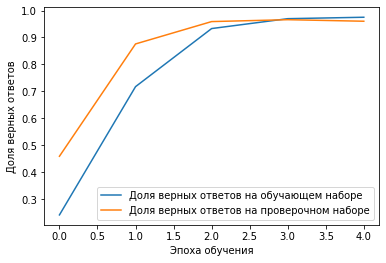

In [130]:
plt.plot(history_cnn.history['accuracy'],
        label="Доля верных ответов на обучающем наборе")
plt.plot(history_cnn.history['val_accuracy'],
        label="Доля верных ответов на проверочном наборе")
plt.xlabel("Эпоха обучения")
plt.ylabel("Доля верных ответов")
plt.legend()
plt.show()

## Сеть LSTM

In [137]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 32, input_length=max_job_len))
model_lstm.add(LSTM(16))
model_lstm.add(Dense(len(uniq), activation='softmax'))

In [138]:
model_lstm.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [139]:
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 32)            320000    
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense_3 (Dense)             (None, 130)               2210      
                                                                 
Total params: 325,346
Trainable params: 325,346
Non-trainable params: 0
_________________________________________________________________


In [140]:
model_lstm_save_path = '../Neural Networks/best_model_lstm_v2.h5'
callback_lstm = ModelCheckpoint(model_lstm_save_path,
                               monitor='val_accuracy',
                               save_best_only=True,
                               verbose=1)

In [141]:
history_lstm = model_lstm.fit(x_train,
                             y_train,
                             epochs=40,
                             batch_size=128,
                             validation_split=0.2,
                             callbacks=[callback_lstm])

Epoch 1/40
96/98 [============================>.] - ETA: 0s - loss: 4.4875 - accuracy: 0.0369
Epoch 1: val_accuracy improved from -inf to 0.07827, saving model to ../Neural Networks\best_model_lstm_v2.h5
98/98 [==============================] - 4s 22ms/step - loss: 4.4793 - accuracy: 0.0378 - val_loss: 4.0209 - val_accuracy: 0.0783
Epoch 2/40
97/98 [============================>.] - ETA: 0s - loss: 3.8494 - accuracy: 0.1451
Epoch 2: val_accuracy improved from 0.07827 to 0.18115, saving model to ../Neural Networks\best_model_lstm_v2.h5
98/98 [==============================] - 2s 18ms/step - loss: 3.8488 - accuracy: 0.1454 - val_loss: 3.7636 - val_accuracy: 0.1812
Epoch 3/40
96/98 [============================>.] - ETA: 0s - loss: 3.7012 - accuracy: 0.1864
Epoch 3: val_accuracy improved from 0.18115 to 0.18275, saving model to ../Neural Networks\best_model_lstm_v2.h5
98/98 [==============================] - 2s 18ms/step - loss: 3.6991 - accuracy: 0.1867 - val_loss: 3.6607 - val_accuracy:

Epoch 26/40
97/98 [============================>.] - ETA: 0s - loss: 0.3551 - accuracy: 0.9614
Epoch 26: val_accuracy improved from 0.92236 to 0.92716, saving model to ../Neural Networks\best_model_lstm_v2.h5
98/98 [==============================] - 2s 18ms/step - loss: 0.3562 - accuracy: 0.9612 - val_loss: 0.5303 - val_accuracy: 0.9272
Epoch 27/40
97/98 [============================>.] - ETA: 0s - loss: 0.3353 - accuracy: 0.9634
Epoch 27: val_accuracy improved from 0.92716 to 0.92971, saving model to ../Neural Networks\best_model_lstm_v2.h5
98/98 [==============================] - 2s 18ms/step - loss: 0.3358 - accuracy: 0.9633 - val_loss: 0.5022 - val_accuracy: 0.9297
Epoch 28/40
96/98 [============================>.] - ETA: 0s - loss: 0.3129 - accuracy: 0.9659
Epoch 28: val_accuracy improved from 0.92971 to 0.93163, saving model to ../Neural Networks\best_model_lstm_v2.h5
98/98 [==============================] - 2s 18ms/step - loss: 0.3118 - accuracy: 0.9661 - val_loss: 0.4965 - val_

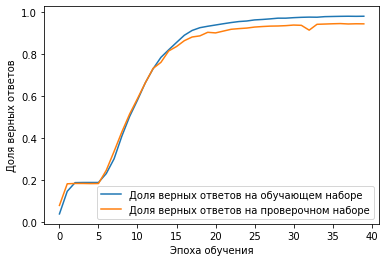

In [142]:
plt.plot(history_lstm.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Сеть GRU

In [143]:
model_gru = Sequential()
model_gru.add(Embedding(num_words, 32, input_length=max_job_len))
model_gru.add(GRU(16))
model_gru.add(Dense(len(uniq), activation='softmax'))

In [144]:
model_gru.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [145]:
model_gru.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 32)            320000    
                                                                 
 gru (GRU)                   (None, 16)                2400      
                                                                 
 dense_4 (Dense)             (None, 130)               2210      
                                                                 
Total params: 324,610
Trainable params: 324,610
Non-trainable params: 0
_________________________________________________________________


In [146]:
model_gru_save_path = '../Neural Networks/best_model_gru_v2.h5'
callback_gru = ModelCheckpoint(model_gru_save_path, 
                              monitor='val_accuracy',
                              save_best_only=True,
                              verbose=1)

In [147]:
history_gru = model_gru.fit(x_train, 
                           y_train, 
                           epochs=20,
                           batch_size=128,
                           validation_split=0.1,
                           callbacks=[callback_gru])

Epoch 1/20
110/111 [============================>.] - ETA: 0s - loss: 4.4256 - accuracy: 0.0996
Epoch 1: val_accuracy improved from -inf to 0.10735, saving model to ../Neural Networks\best_model_gru_v2.h5
111/111 [==============================] - 4s 21ms/step - loss: 4.4253 - accuracy: 0.0997 - val_loss: 3.9090 - val_accuracy: 0.1073
Epoch 2/20
111/111 [==============================] - ETA: 0s - loss: 3.8698 - accuracy: 0.1012
Epoch 2: val_accuracy did not improve from 0.10735
111/111 [==============================] - 2s 18ms/step - loss: 3.8698 - accuracy: 0.1012 - val_loss: 3.8241 - val_accuracy: 0.1073
Epoch 3/20
110/111 [============================>.] - ETA: 0s - loss: 3.7033 - accuracy: 0.1059
Epoch 3: val_accuracy improved from 0.10735 to 0.13994, saving model to ../Neural Networks\best_model_gru_v2.h5
111/111 [==============================] - 2s 18ms/step - loss: 3.7032 - accuracy: 0.1060 - val_loss: 3.5751 - val_accuracy: 0.1399
Epoch 4/20
109/111 [========================

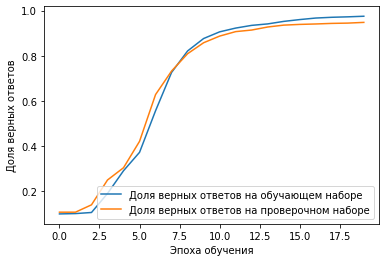

In [148]:
plt.plot(history_gru.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_gru.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Тестируем

In [149]:
test = pd.read_csv("../Data/test.csv", sep=',', index_col='index')

In [150]:
test

name  \
index                                                          
26461447              персональный водитель сервиса "wheely"   
26464220                          менеджер по автоперевозкам   
26467473                 продавец кассир (тц "седанка сити")   
26468989                                специалист по кадрам   
26471705                           администратор на телефоне   
...                                                      ...   
123809156      рабочий по благоустройству населенных пунктов   
104700805                      менеджер по подбору персоналу   
114563177         продавец кассир (воронеж циолковского 125)   
354950498                                           весовщик   
361611956  диспетчер производства логистики (помощник рук...   

                                                 description  
index                                                         
26461447   <p><strong>В </strong>связи с расширением авто...  
26464220   <strong>Обязанности:</strong> <ul> <li>Поиск п...  
26467473   <p><strong>Твои обязанности:</strong></p> <ul>...  
26468989   <p>Обязанности:</p> <p>- оформление приема, пе...  
26471705   <strong>Обязанности:</strong> <ul> <li> <p>Обр...  
...                                                      ...  
123809156  Уборка территории от бытового мусора, сорной р...  
104700805  <b>Обязанности:</b> <br /><ul><li>Проведение с...  
114563177  <p><strong>Для каждого, кто хочет работать и з...  
354950498  <p>&nbsp;Взвешивание грузов на автомобильных э...  
361611956  <p>Наша компания, с солидным опытом в производ...  

[1090 rows x 2 columns]

In [151]:
test = test.merge(responsibilities.rename("responsibilities"), how='left', left_index=True, right_index=True)

In [152]:
test

name  \
index                                                          
26461447              персональный водитель сервиса "wheely"   
26464220                          менеджер по автоперевозкам   
26467473                 продавец кассир (тц "седанка сити")   
26468989                                специалист по кадрам   
26471705                           администратор на телефоне   
...                                                      ...   
123809156      рабочий по благоустройству населенных пунктов   
104700805                      менеджер по подбору персоналу   
114563177         продавец кассир (воронеж циолковского 125)   
354950498                                           весовщик   
361611956  диспетчер производства логистики (помощник рук...   

                                                 description  \
index                                                          
26461447   <p><strong>В </strong>связи с расширением авто...   
26464220   <strong>Обязанности:</strong> <ul> <li>Поиск п...   
26467473   <p><strong>Твои обязанности:</strong></p> <ul>...   
26468989   <p>Обязанности:</p> <p>- оформление приема, пе...   
26471705   <strong>Обязанности:</strong> <ul> <li> <p>Обр...   
...                                                      ...   
123809156  Уборка территории от бытового мусора, сорной р...   
104700805  <b>Обязанности:</b> <br /><ul><li>Проведение с...   
114563177  <p><strong>Для каждого, кто хочет работать и з...   
354950498  <p>&nbsp;Взвешивание грузов на автомобильных э...   
361611956  <p>Наша компания, с солидным опытом в производ...   

                                            responsibilities  
index                                                         
26461447   Выполнение поступающих заявок через приложение...  
26464220                                   Поиск поставщиков  
26467473   обслуживание покупателей в торговом зале, в зо...  
26468989   оформление приема, перевода и увольнение сотру...  
26471705       Обработка входящих горячих заявок от клиентов  
...                                                      ...  
123809156  Уборка территории от бытового мусора, сорной р...  
104700805                           Проведение собеседований  
114563177  Обслуживание покупателей на кассе (наличный и ...  
354950498                                               nbsp  
361611956  поиск и выбор подрядчика  грамотное составлени...  

[1090 rows x 3 columns]

In [153]:
display(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1090 entries, 26461447 to 361611956
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              1090 non-null   object
 1   description       1090 non-null   object
 2   responsibilities  908 non-null    object
dtypes: object(3)
memory usage: 66.4+ KB


None

In [154]:
test["full_description"] = (
    test["name"] + " " + test["responsibilities"].fillna("")
).map(str.lower)
display(test.head(3))

name  \
index                                              
26461447  персональный водитель сервиса "wheely"   
26464220              менеджер по автоперевозкам   
26467473     продавец кассир (тц "седанка сити")   

                                                description  \
index                                                         
26461447  <p><strong>В </strong>связи с расширением авто...   
26464220  <strong>Обязанности:</strong> <ul> <li>Поиск п...   
26467473  <p><strong>Твои обязанности:</strong></p> <ul>...   

                                           responsibilities  \
index                                                         
26461447  Выполнение поступающих заявок через приложение...   
26464220                                  Поиск поставщиков   
26467473  обслуживание покупателей в торговом зале, в зо...   

                                           full_description  
index                                                        
26461447  персональный водитель сервиса "wheely" выполне...  
26464220       менеджер по автоперевозкам поиск поставщиков  
26467473  продавец кассир (тц "седанка сити") обслуживан...

In [167]:
test.loc[:, "full_description"] = test["full_description"].str.replace(
    patt, " ", regex=True
)
display(test.head(3))

name  \
index                                              
26461447  персональный водитель сервиса "wheely"   
26464220              менеджер по автоперевозкам   
26467473     продавец кассир (тц "седанка сити")   

                                                description  \
index                                                         
26461447  <p><strong>В </strong>связи с расширением авто...   
26464220  <strong>Обязанности:</strong> <ul> <li>Поиск п...   
26467473  <p><strong>Твои обязанности:</strong></p> <ul>...   

                                           responsibilities  \
index                                                         
26461447  Выполнение поступающих заявок через приложение...   
26464220                                  Поиск поставщиков   
26467473  обслуживание покупателей в торговом зале, в зо...   

                                           full_description  
index                                                        
26461447  персональный водитель сервиса  wheely  выполне...  
26464220       менеджер по автоперевозкам поиск поставщиков  
26467473  продавец кассир  тц  седанка сити   обслуживан...

In [179]:
test_sequences = tokenizer.texts_to_sequences(test['full_description'])

In [180]:
x_test = pad_sequences(test_sequences, maxlen=max_job_len)

In [181]:
x_test[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0, 8390,    9,
         985,   14, 1515,  275, 1239, 6230],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   12,    3,  231,  707],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    8,   23,  128, 2889,   49,   70,    2,  276,  210,
           2, 1878, 65

In [182]:
model_cnn.load_weights(model_cnn_save_path)

In [183]:
test.full_description.iloc[0]

'персональный водитель сервиса  wheely  выполнение поступающих заявок через приложение wheely'

In [185]:
predictions = model_cnn.predict(x_test)

35/35 [==============================] - 0s 4ms/step


In [187]:
predictions

array([[5.3460964e-05, 8.3334319e-04, 1.8750277e-03, ..., 7.3095265e-07,
        3.7160280e-04, 2.8644522e-06],
       [4.4055509e-05, 7.6517620e-04, 6.7602448e-02, ..., 6.8488534e-06,
        6.4592441e-06, 6.8376118e-09],
       [3.7861367e-16, 8.3807041e-17, 4.2935735e-11, ..., 8.8468925e-17,
        1.7642475e-06, 1.1174514e-10],
       ...,
       [4.8783656e-16, 1.5862221e-16, 8.1864522e-11, ..., 1.6563584e-16,
        2.8255722e-06, 1.2034947e-10],
       [1.5931806e-04, 4.8950417e-03, 4.6865642e-03, ..., 1.2721461e-05,
        1.3944636e-04, 1.3209745e-05],
       [1.4439414e-04, 1.9683061e-05, 4.5242423e-06, ..., 2.9527846e-01,
        6.4602586e-06, 5.0345284e-04]], dtype=float32)

In [199]:
class_pred = pd.Series(np.argmax(predictions, axis=1))

In [200]:
class_pred

0       114
1        30
2        76
3        30
4        64
       ... 
1085     66
1086     30
1087     76
1088     47
1089     67
Length: 1090, dtype: int64

In [201]:
target_pred = class_pred.map(lambda x: token[x])

In [202]:
target_pred

0       8322
1       2432
2       5223
3       2432
4       4222
        ... 
1085    4224
1086    2432
1087    5223
1088    3312
1089    4323
Length: 1090, dtype: int64

In [207]:
target_pred.values

array([8322, 2432, 5223, ..., 5223, 3312, 4323], dtype=int64)

In [203]:
test.index

Int64Index([ 26461447,  26464220,  26467473,  26468989,  26471705,  26476036,
             26480630,  26480759,  26483824,  26483941,
            ...
            169906959,  39486584, 125993733,  35926971, 166397492, 123809156,
            104700805, 114563177, 354950498, 361611956],
           dtype='int64', name='index', length=1090)

In [209]:
submission = pd.DataFrame({'index': test.index,
                          'target': target_pred.values})

In [210]:
submission

index  target
0      26461447    8322
1      26464220    2432
2      26467473    5223
3      26468989    2432
4      26471705    4222
...         ...     ...
1085  123809156    4224
1086  104700805    2432
1087  114563177    5223
1088  354950498    3312
1089  361611956    4323

[1090 rows x 2 columns]

In [211]:
submission.to_csv('../Results/submission_v1.csv', index=False)

In [212]:
model_lstm.load_weights(model_lstm_save_path)

In [213]:
predictions_lstm = model_lstm.predict(x_test)

35/35 [==============================] - 1s 4ms/step


In [214]:
class_pred_lstm = pd.Series(np.argmax(predictions_lstm, axis=1))

In [215]:
target_pred_lstm = class_pred_lstm.map(lambda x: token[x])

In [216]:
submission_lstm = pd.DataFrame({'index': test.index,
                          'target': target_pred_lstm.values})

In [217]:
submission_lstm.to_csv('../Results/submission_lstm_v1.csv', index=False)